Import the Python modules needed for the solution.

In [17]:
import random
import math
import matplotlib.pyplot as plt

Define constants to be used.

In [18]:
INITIAL_PHEROMONE_VALUE = 0.0001

Create a Graph class, which contains both cost and pheromone information

In [19]:
class Graph(object):
    def __init__(self, distance: list, matrixSize: int):
        self.matrix = distance
        self.matrixSize = matrixSize
        self.pheromone = [[INITIAL_PHEROMONE_VALUE for j in range(matrixSize)] for i in range(matrixSize)]

Define the Ant Colony class

In [20]:
class ACO(object):
    def __init__(self, numberOfAnts: int, generations: int, pheromoneWeight: float, distanceWeight: float, evaporation: float, pheromoneIntensity: int):
        self.pheromoneIntensity = pheromoneIntensity
        self.evaporation = evaporation
        self.distanceWeight = distanceWeight
        self.pheromoneWeight = pheromoneWeight
        self.numberOfAnts = numberOfAnts
        self.generations = generations

    def updatePheromone(self, graph: Graph, ants: list):
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                graph.pheromone[i][j] *= self.evaporation # All of the paths evaporate over time
                for ant in ants:
                    graph.pheromone[i][j] += ant.localAntPheromone[i][j] # Update the pheromone information based on the information of each ant

    def solve(self, graph: Graph):
        bestCost = float('inf') # Set the best path distance to infinity
        bestSolution = []
        for gen in range(self.generations): # For each generation create a new set of ants
            ants = [Ant(self, graph) for i in range(self.numberOfAnts)]
            for ant in ants:
                for i in range(graph.matrixSize - 1):
                    ant.selectNext() # Each ant moves through the graph to create a possible solution
                ant.totalCost += graph.matrix[ant.visitedCities[-1]][ant.visitedCities[0]]
                if ant.totalCost < bestCost:
                    bestCost = ant.totalCost
                    bestSolution = [] + ant.visitedCities

                ant.updateLocalPheromone()
            self.updatePheromone(graph, ants) # the pheromone levels on the edges are updated
        return bestCost, bestSolution

Define the Ant Class

In [21]:
class Ant(object):
    def __init__(self, aco: ACO, graph: Graph):
        self.colony = aco
        self.graph = graph
        self.totalCost = 0.0
        self.visitedCities = []  # List of visited cities
        self.localAntPheromone = []  # the local increase of pheromone
        self.allowedCities = [i for i in range(graph.matrixSize)]  # nodes which are allowed for the next selection
        self.costMatrix = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.matrixSize)] for i in
                    range(graph.matrixSize)]  # heuristic information
        start = random.randint(0, graph.matrixSize - 1)  # start from any node
        self.visitedCities.append(start)
        self.current = start
        self.allowedCities.remove(start)

    def selectNext(self):
        summedWeight = 0
        # Sum the whole weight of all unvisited cities
        for i in self.allowedCities:
            summedWeight += self.graph.pheromone[self.current][i] ** self.colony.pheromoneWeight * self.costMatrix[self.current][
                                                                                            i] ** self.colony.distanceWeight
        probabilities = [0 for i in range(self.graph.matrixSize)]  # probabilities for moving to a node in the next step
        for i in range(self.graph.matrixSize):
          if i in self.allowedCities:
                    # Calculate the probability of each city to be visited next
            probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.pheromoneWeight * \
                    self.costMatrix[self.current][i] ** self.colony.distanceWeight / summedWeight

        # Randomly select a city
        selected = 0
        rand = random.random()

        # For higher probability it is more likely to be selected
        for i, probability in enumerate(probabilities):
          rand -= probability

          if rand <= 0:
            selected = i
            break
        self.allowedCities.remove(selected)
        self.visitedCities.append(selected)
        self.totalCost += self.graph.matrix[self.current][selected]
        self.current = selected

    def updateLocalPheromone(self):
        self.localAntPheromone = [[0 for j in range(self.graph.matrixSize)] for i in range(self.graph.matrixSize)]
        for _ in range(1, len(self.visitedCities)):
            i = self.visitedCities[_ - 1]
            j = self.visitedCities[_]
            self.localAntPheromone[i][j] = self.colony.pheromoneIntensity

Plot Method for visualization

In [22]:
def plot(points, path: list):
    x = []
    y = []
    for point in points:
        x.append(point[0])
        y.append(point[1])
    plt.plot(x, y, 'co')
    for i in range (0, len(path)):
        plt.annotate(i, (x[i], y[i]))
    for _ in range(1, len(path)):
        i = path[_ - 1]
        j = path[_]
        plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='r', length_includes_head=True)

    plt.show()

Method for calculating the distance between the cities

In [23]:
def distance(city1: dict, city2: dict):
    return math.sqrt((city1['x'] - city2['x']) ** 2 + (city1['y'] - city2['y']) ** 2)

Main method


cost: 15601.919532918737, path: [14, 13, 11, 12, 10, 22, 15, 4, 5, 6, 1, 3, 7, 8, 9, 2, 17, 16, 18, 23, 24, 19, 20, 21, 25, 27, 26, 29, 30, 28, 0]


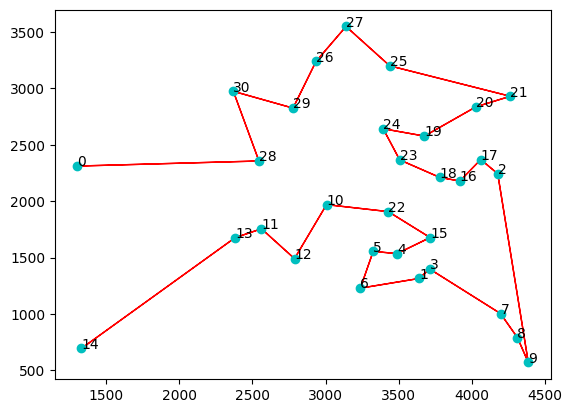

In [24]:
def main():
    cities = []
    points = []
    with open('./chn31.txt') as f:
        for line in f.readlines():
            city = line.split(' ')
            cities.append(dict(index=int(city[0]), x=int(city[1]), y=int(city[2])))
            points.append((int(city[1]), int(city[2])))
    distanceMatrix = []
    matrixSize = len(cities)
    for i in range(matrixSize):
        row = []
        for j in range(matrixSize):
            row.append(distance(cities[i], cities[j]))
        distanceMatrix.append(row)
    #Here we save the distances and then we will get the inverted values
    aco = ACO(100, 100, 1.0, 10.0, 0.5, 1)
    graph = Graph(distanceMatrix, matrixSize)
    cost, path = aco.solve(graph)
    print('cost: {}, path: {}'.format(cost, path))
    plot(points, path)

if __name__ == '__main__':
    main()